# Training file for RDN

## Imports

In [69]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import src.nntools as nt
from src.CarlaDataset import CarlaDataset, CarlaDatasetPatch
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()


if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

from src.rdn import RDN

print(device)

cuda


# Utility function

In [70]:
class SuperResolutionStatsManager(nt.StatsManager):
    def __init__(self):
        super(SuperResolutionStatsManager, self).__init__()

    def init(self):
        super(SuperResolutionStatsManager, self).init()
        # Initializing `self.running_psnr`
        self.running_psnr = 0
        self.running_ssim = 0

    def accumulate(self, loss, x, y, d):
        super(SuperResolutionStatsManager, self).accumulate(loss, x, y, d)
        # Updating `self.running_psnr`
        d_numpy = d.detach().to('cpu').numpy()
        y_numpy = y.detach().to('cpu').numpy()

        self.running_psnr += metrics.peak_signal_noise_ratio(d_numpy, y_numpy)

        current_ssim = 0

        for i in range(d_numpy.shape[0]):
            d_numpy_temp = np.moveaxis(d_numpy[i], [0, 1, 2], [2, 0, 1])
            y_numpy_temp = np.moveaxis(y_numpy[i], [0, 1, 2], [2, 0, 1])

            value_range = max(d_numpy_temp.max(), y_numpy_temp.max()) - min(d_numpy_temp.min(), y_numpy_temp.min())
            
            current_ssim += metrics.structural_similarity(d_numpy_temp, y_numpy_temp, win_size=7, data_range=value_range, multichannel=True, channel_axis=2)
        
        self.running_ssim += current_ssim / d_numpy.shape[0]

    def summarize(self):
        loss = super(SuperResolutionStatsManager, self).summarize()
        psnr = self.running_psnr / (self.number_update+1e-9 )
        ssim = self.running_ssim / (self.number_update+1e-9 )
        return {'loss': loss, 'psnr': psnr, "ssim": ssim}

def criterion(y, d):
    return F.mse_loss(y, d)

#show image
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    # ax.axis('off')
    return h

## Data loader

In [71]:
new_img_size = 256
common_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    common_transform,
    #transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(size=(new_img_size, new_img_size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
])

valid_transform = transforms.Compose([
    common_transform,
    #transforms.CenterCrop((new_img_size, new_img_size)),
])

In [72]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import your datasetclass

PATCH_SIZE = 32

X_train = CarlaDatasetPatch("1920x1080", "960x540", "train", transforms=train_transform, download=True, patch_size=PATCH_SIZE)
X_valid = CarlaDatasetPatch("1920x1080", "960x540", "test", transforms=train_transform, download=True, patch_size=PATCH_SIZE)
#X_train.get_info()

#train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
#valid_loader = DataLoader(X_valid, batch_size=32, shuffle=True)

Dataset already present
Dataset already present


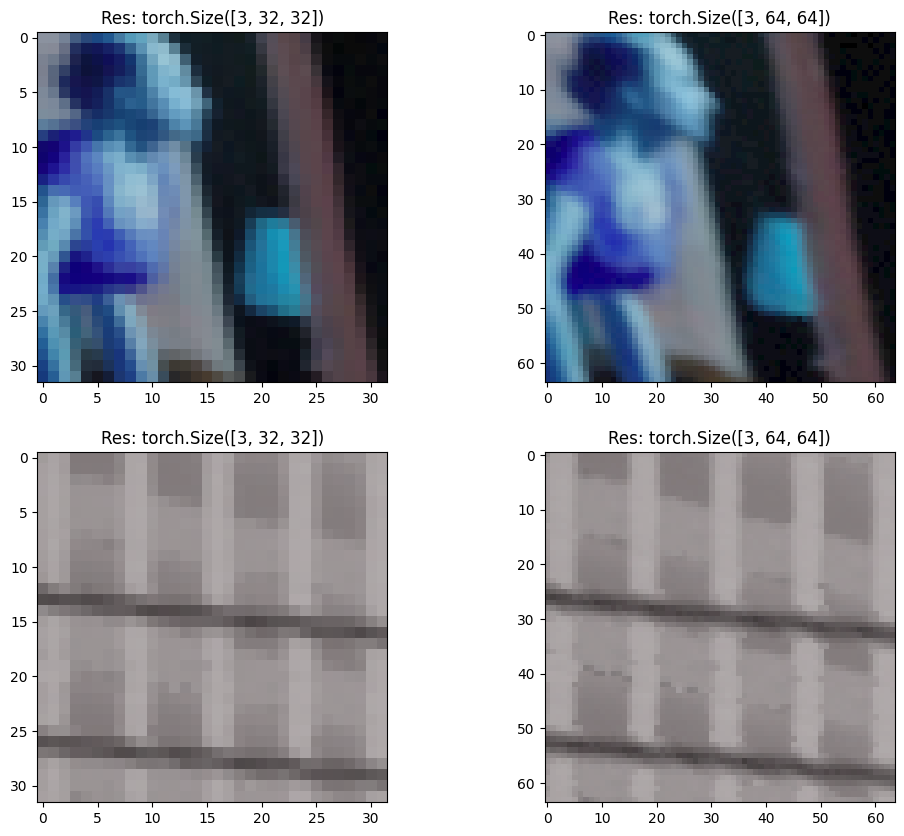

In [73]:
#printing some 2 pairs of low res/high res images
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ex_low_res1, ex_high_res1 = X_train[np.random.randint(len(X_train))]
ex_low_res2, ex_high_res2 = X_train[np.random.randint(len(X_train))]
ex = [ex_low_res1, ex_high_res1, ex_low_res2, ex_high_res2]
for i, ax in enumerate(axes.flat):
    ax.set_title(f'Res: {ex[i].shape}')
    myimshow(ex[i], ax=ax)

In [74]:
# Plot for the the predicted image, low resolution image and high resolution image in first row
# plot Plot the loss, psnr and ssim curves in the second row
def plot_images_and_metrics(exp, fig, axes, dataset, index): ##Only to use when perform_validation_during_training == True
    low_res, high_res = dataset[index]

    with torch.no_grad():
        predicted_res = exp.net(low_res.to(device))[0]

    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    axes[1][2].clear()

    axes[0][0].set_title(f'Low res: {low_res.detach().cpu().numpy().shape}')
    axes[0][1].set_title(f'High res: {high_res.detach().cpu().numpy().shape}')
    axes[0][2].set_title(f'Predicted res: {predicted_res.detach().cpu().numpy().shape}')

    axes[0][0].imshow(low_res.detach().cpu().numpy().transpose(1, 2, 0))
    axes[0][1].imshow(high_res.detach().cpu().numpy().transpose(1, 2, 0))
    axes[0][2].imshow(predicted_res.detach().cpu().numpy().transpose(1, 2, 0))

    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="Train loss")
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="Train psnr")
    axes[1][2].plot([exp.history[k][0]['ssim'] for k in range(exp.epoch)], label="Train ssim")

    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="Eval loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], label="Eval psnr")
    axes[1][2].plot([exp.history[k][1]['ssim'] for k in range(exp.epoch)], label="Eval ssim")

    axes[1][0].legend()
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")        
    axes[1][1].legend()
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR") 
    axes[1][2].legend()
    axes[1][2].set_xlabel("Epoch")
    axes[1][2].set_ylabel("SSIM")

## Experiment on a small batch

In [75]:
dataset_size = 10
small_dataset = [X_train[np.random.randint(len(X_train))] for _ in range(dataset_size)]


small_train_size = int(0.8 * len(small_dataset))
small_valid_size = len(small_dataset) - small_train_size
small_train_dataset, small_valid_dataset = torch.utils.data.random_split(small_dataset, [small_train_size, small_valid_size])

torch.cuda.empty_cache()

lr = 1e-3
r = RDN(C=6 , D=20, G=64, G0=64, scaling_factor=2, kernel_size=3, c_dims=X_train[0][0].shape[0], upscaling='shuffle', weights=None)
r = r.to(device)
# In mega bytes
print("Size of model mb", sum(p.numel() for p in r.parameters() if p.requires_grad) / (1024 * 1024))
# Size of batch in mega bytes
print("Size of batch mb", small_dataset[0][0].shape[0] * small_dataset[0][0].shape[1] * small_dataset[0][0].shape[2] * 4 / (1024 * 1024))

adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
path = "results/smallbatchexperiement4"
exp = nt.Experiment(r, small_dataset, small_valid_dataset, adam, stats_manager, device, criterion, batch_size=1,
                     output_dir=path, perform_validation_during_training=True)

Size of model mb 15.593994140625
Size of batch mb 0.01171875


Start/Continue training from epoch 300
Finish training for 300 epochs


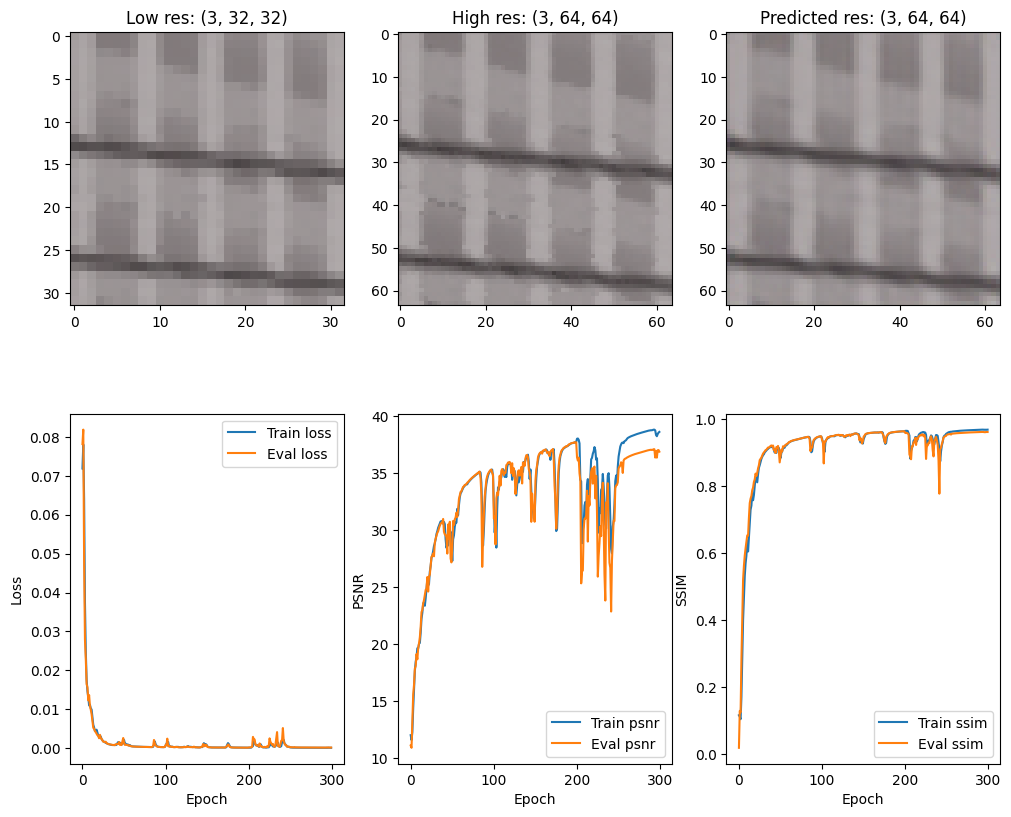

In [76]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 10))
exp.run(num_epochs=300, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, small_valid_dataset, np.random.randint(len(small_valid_dataset))))

3


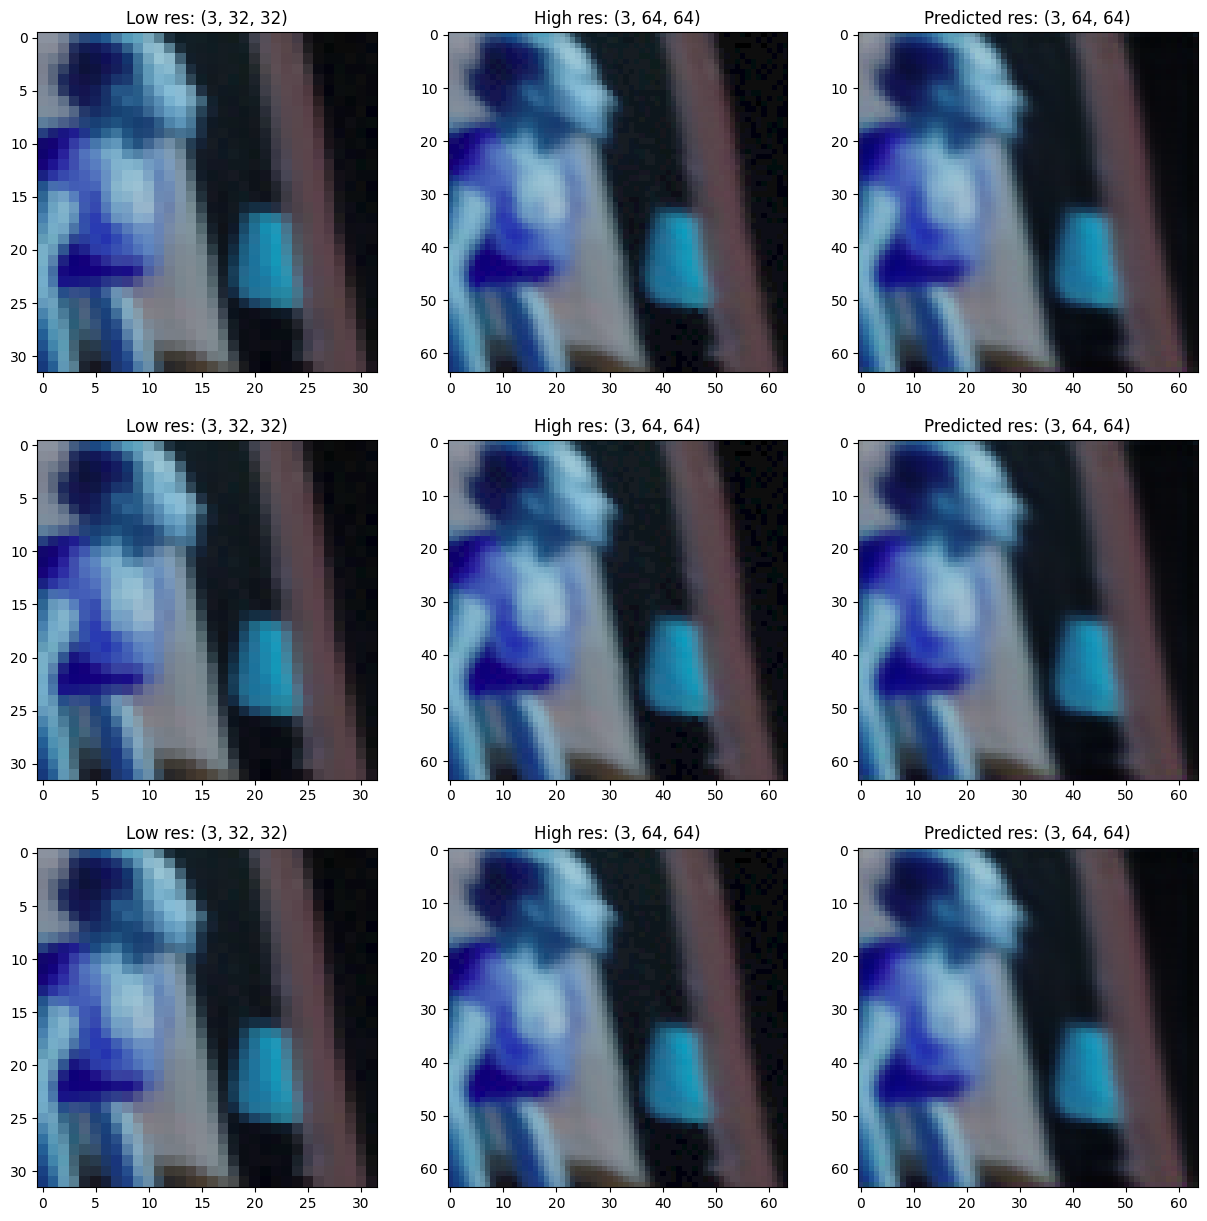

In [77]:
# Show three images for a set and predict it
def plot_images_from_model(model, dataset, num_images=1, indices=None):
    images = []

    num_images = max(num_images, len(indices) if indices else 0)

    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    print(num_images)

    for i in range(num_images):
        if indices:
            low_res, high_res = dataset[indices[i]]
        else:
            low_res, high_res = dataset[np.random.randint(len(dataset))]

        images.append(low_res)
        images.append(high_res)

        with torch.no_grad():
            predicted_res = model.net(low_res.to(device))[0]

        images.append(predicted_res)

        axes[i, 0].set_title(f'Low res: {low_res.detach().cpu().numpy().shape}')
        axes[i, 1].set_title(f'High res: {high_res.detach().cpu().numpy().shape}')
        axes[i, 2].set_title(f'Predicted res: {predicted_res.detach().cpu().numpy().shape}')

        axes[i, 0].imshow(low_res.detach().cpu().numpy().transpose(1, 2, 0))
        axes[i, 1].imshow(high_res.detach().cpu().numpy().transpose(1, 2, 0))
        axes[i, 2].imshow(predicted_res.detach().cpu().numpy().transpose(1, 2, 0))
    
    plt.show()


In [ ]:
plot_images_from_model(exp, small_dataset, indices=[0, 1, 2])

# Training the data

In [78]:
train_size = int(0.8 * len(X_train))
valid_size = len(X_train) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(X_train, [train_size, valid_size])

In [79]:
torch.cuda.empty_cache()

lr = 1e-3
batch_size = 32
r = RDN(C=6 , D=20, G=64, G0=64, scaling_factor=2, kernel_size=3, c_dims=X_train[0][0].shape[0], upscaling='shuffle', weights=None)
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
path = "results/superresol1000"
exp1 = nt.Experiment(r, train_dataset, valid_dataset, adam, stats_manager, device, criterion, batch_size=batch_size,
                     output_dir=path, perform_validation_during_training=True)

Start/Continue training from epoch 23


TypeError: plot_images_and_metrics() takes from 2 to 4 positional arguments but 5 were given

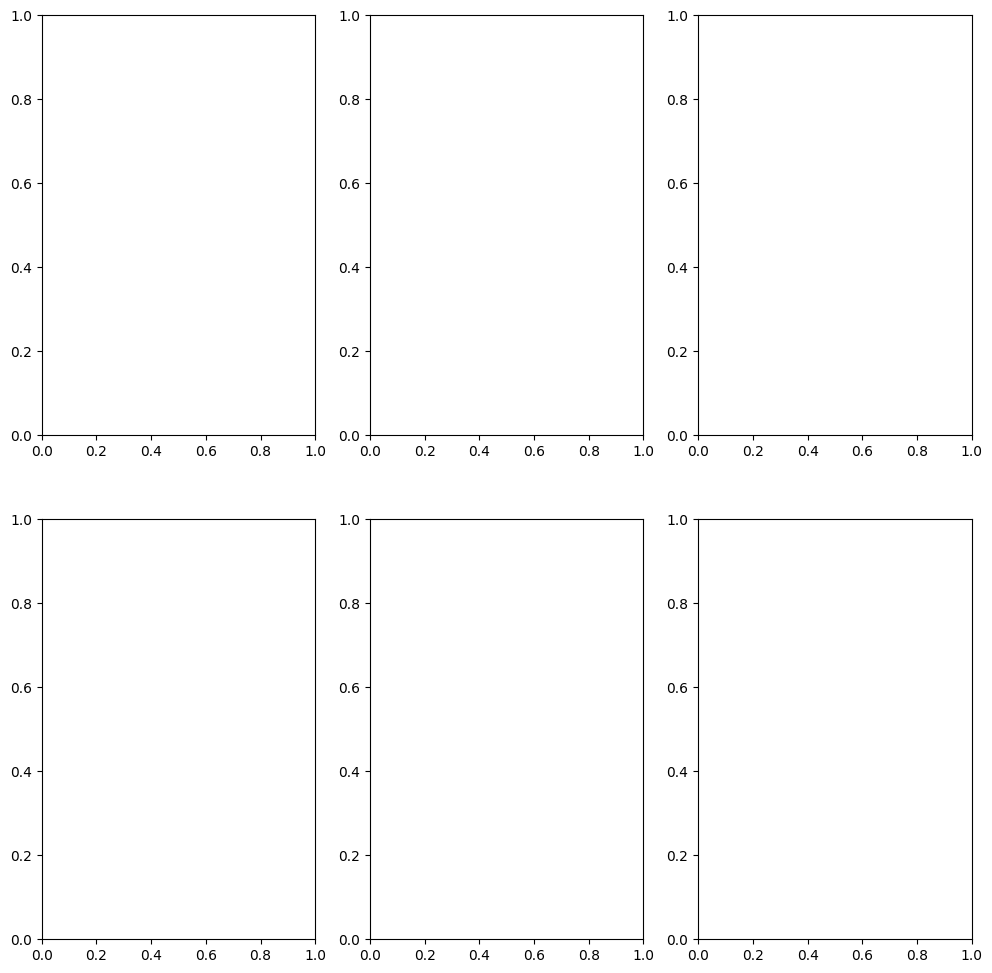

In [80]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
exp1.run(num_epochs=23, plot=lambda exp: plot_images_and_metrics(exp, fig, axes, X_valid, np.random.randint(len(X_valid))))
#exp1.run(num_epochs=3, plot=None)

8


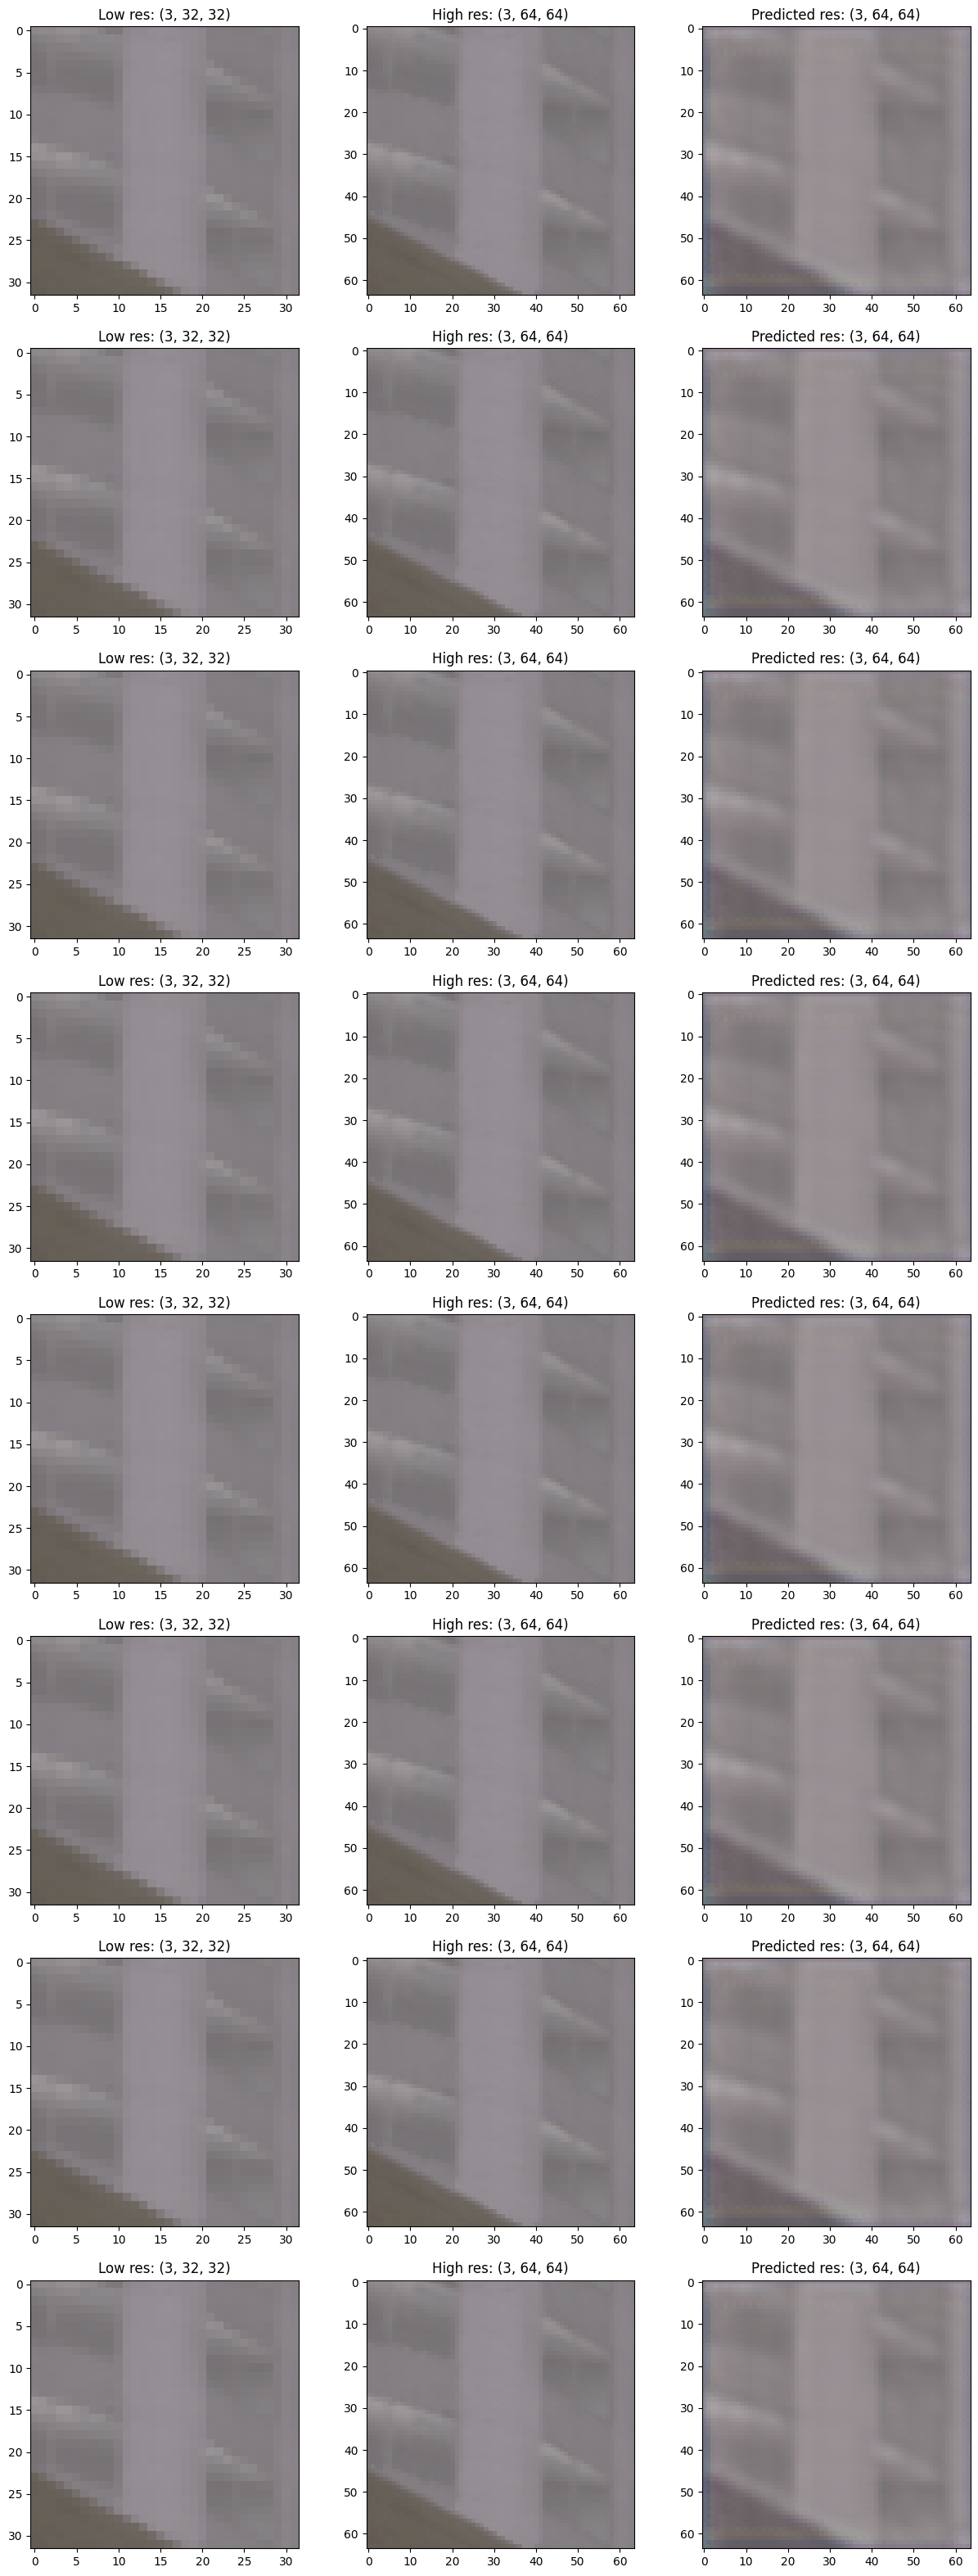

200


In [ ]:
plot_images_from_model(exp1, X_valid, num_images=4)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

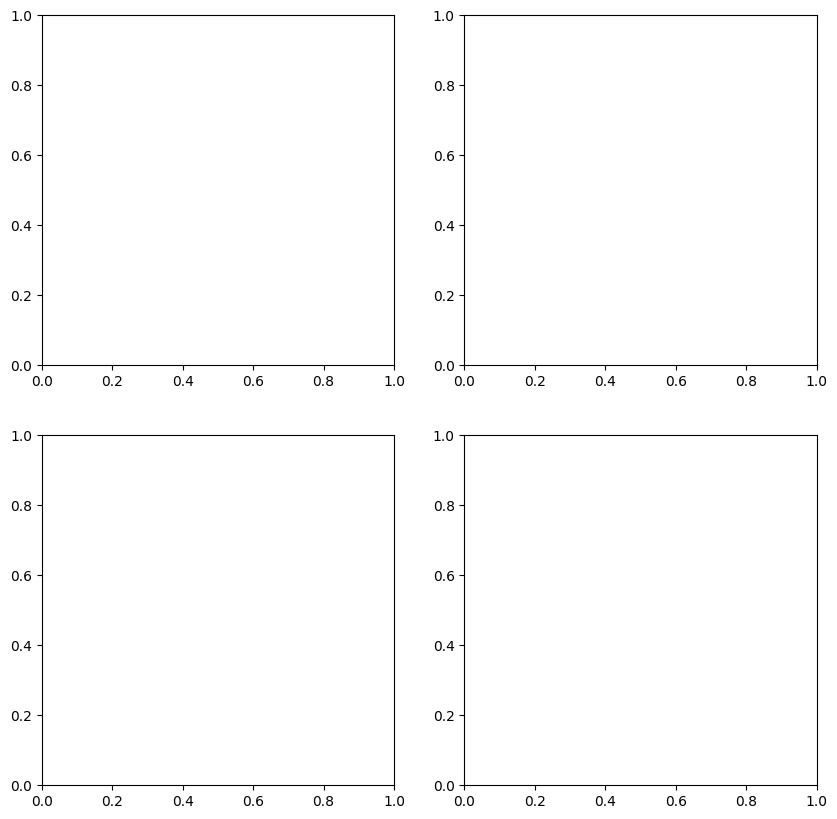

In [ ]:
plot_images_from_model(exp1, X_valid, num_images=4)

## Reconstruct image from patch

In [ ]:
def predict_full_image_by_patch(model, image, patch_size=32):
    """
    Predicts the full image by splitting it into patches and then reconstructing it.
    """
    # Split the image into patches
    patches = []
    for i in range(0, image.shape[1], patch_size):
        for j in range(0, image.shape[2], patch_size):
            patch = image[:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)

    # Predict the patches
    with torch.no_grad():
        predicted_patches = [model(patch.to(device))[0] for patch in patches]

    # Reconstruct the image
    predicted_image = torch.zeros(image.shape)
    for i in range(0, image.shape[1], patch_size):
        for j in range(0, image.shape[2], patch_size):
            patch = predicted_patches.pop(0)
            predicted_image[:, i:i+patch_size, j:j+patch_size] = patch

    return predicted_image

RuntimeError: The expanded size of the tensor (32) must match the existing size (64) at non-singleton dimension 2.  Target sizes: [3, 32, 32].  Tensor sizes: [3, 64, 64]

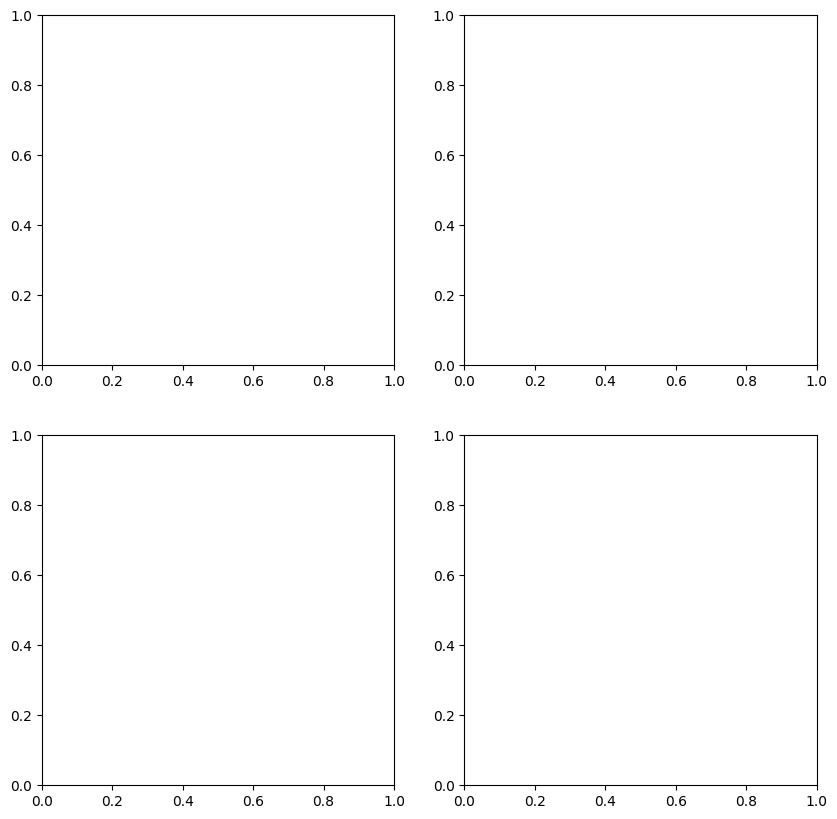

In [ ]:
## Test on one image from the train and test set

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
test_low_res1, test_high_res1 = X_train[np.random.randint(len(X_train))]
test_low_res2, test_high_res2 = X_valid[np.random.randint(len(X_valid))]
pred_high_res1 = predict_full_image_by_patch(exp.net, test_low_res1)
pred_high_res2 = predict_full_image_by_patch(exp1.net, test_low_res2)
ex = [test_high_res1, pred_high_res1, test_high_res2, pred_high_res2]
for i, ax in enumerate(axes.flat):
    if i%2 == 0:
        ax.set_title(f'HR image: {ex[i].detach().cpu().numpy().shape}')
    else:
         ax.set_title(f'HR predicted image: {ex[i].detach().cpu().numpy().shape}')
    myimshow(ex[i], ax=ax)
